# Chess retrograde analysis
_Description_

Known Issues:
* Does not work with pawns on the board

## Imports

In [80]:
import chess
from anytree import Node, RenderTree
from math import factorial
from anytree.exporter import DotExporter


## Initial board entry
This will be replaced by @NicoMillers board setup code

In [81]:
fen = "8/8/8/8/4k3/8/8/K6R w - - 0 1"
board = chess.Board(fen)

## Setting up the piece list
The piece list contains all pieces on the board.

In [82]:
#get the piece map from the library
tmp_piece_map = board.piece_map()
pieceList = []
#iterate over the map and append the pieces to the list
for location in tmp_piece_map:
    pieceList.append(tmp_piece_map[location])

## Setting up the boardList
The board list is a list object containing 64! / (64-COUNT(Pieces))! empty boards to be filled later.

In [83]:
tmp_board = chess.Board()
tmp_board.clear()
board_list = []
list_length = factorial(64) // factorial(64 - len(pieceList))

for i in range(list_length):
    board_list.append(tmp_board.copy())

## The placePieces helper function
This function recursively places pieces on the board.
It takes the following arguments:
* boardList: A list containing empty or partially filled board objects
* pieceList: A list containing all pieces which should end up on the board
* pieceIndexStart: Index of the next piece to be placed
* start: range start for where to begin placing pieces in the boardList
* stop: range end for where to end placing pieces in the boardList

//TODO: Comments

In [84]:
def placePieces(boardList, pieceList, pieceIndexStart, start, stop):
    squareIndex = -1 #first Run increments to 0
    offset = (stop - start) // (64 - (len(pieceList) - 1) + pieceIndexStart)
    for i in range(start, stop):
        if i % offset == 0:
            if pieceIndexStart < (len(pieceList)-1) and i - offset > 0:
                placePieces(boardList, pieceList, pieceIndexStart + 1, i - offset, i)
            squareIndex = squareIndex + 1
        square = chess.Square(squareIndex)
        if boardList[i].piece_at(square) is None:
            boardList[i].set_piece_at(square, pieceList[pieceIndexStart])

## Create all possible combinations of pieces on the board

In [85]:
placePieces(board_list, pieceList, 0, 0, len(board_list))

## Check boards for validity and filter out invalid ones

In [86]:
S = []
for board in board_list:
    #Board with white having the next turn
    board.turn = chess.WHITE
    status = board.status()
    if status == chess.Status.VALID or status == chess.Status.OPPOSITE_CHECK:
        S.append(board)
    boardBlackMove = board.copy()
    boardBlackMove.turn = chess.BLACK
    status = boardBlackMove.status()
    #The same board with black having the next turn
    if status == chess.Status.VALID or status == chess.Status.OPPOSITE_CHECK:
        S.append(boardBlackMove)


## Find won boards and add them to S_0
Additionally add them to S_0_ASCII for easier comparison in the next step.

In [87]:
S_tmp = []
S_ASCII = []
S_0 = []
S_0_ASCII = []

for board in S:
    outcome = board.outcome()
    # If True Game has finished in a certain way
    if outcome != None:
        # A winner has been determined
        if outcome.winner is not None and board.is_valid() != False:
            S_0.append(board)
            S_0_ASCII.append((board.turn,board.__str__()))
    # Every other board
    else:
        S_tmp.append(board)
        S_ASCII.append((board.turn, board.__str__()))
S = S_tmp



## OneStepAway Function
This function returns (given two lists of boards) all boards from the second list, that are one move away from one board from the first list.
Additionally, it returns the second list, without the boards in the new list.

In [88]:
def one_step_away(S_n, S):
    s_n1 = []
    s_n1_ascii = []
    s_ascii = []
    s_tmp = []

    for chessBoard in S:
        s_ascii.append((chessBoard.turn, chessBoard.__str__))

    for chessBoard in S_n:
        for pLMove in chessBoard.pseudo_legal_moves:
            chessBoard.push(pLMove)
            if (chessBoard.turn, chessBoard.__str__()) in s_ascii:
                s_n1_ascii.append((chessBoard.turn, chessBoard.__str__()))
            chessBoard.pop()



    for chessBoard in S:
        if(chessBoard.turn, chessBoard.__str__()) in s_n1_ascii:
            s_n1.append(chessBoard)
        else:
            s_tmp.append(chessBoard)

    return s_n1, s_tmp

## Find all boards one step away from winning

In [89]:
S_1_cmp, S_cmp = one_step_away(S_0, S)

S_1 = []
S_1_ASCII = []
counter = 0
# print("WHITE: " + str(chess.WHITE))
# print("BLACK: " + str(chess.BLACK))
for board in S_0:
    # print("Round: " + str(counter))
    # print(board.__str__())
    # print("Turn: " + str(board.turn))
    board.turn = board.turn ^ True
    for move in board.pseudo_legal_moves:
        board.push(move)
        if ((board.turn, board.__str__())) in S_ASCII and board.is_valid():
            S_1_ASCII.append((board.turn, board.__str__()))
        board.pop()
    counter += 1

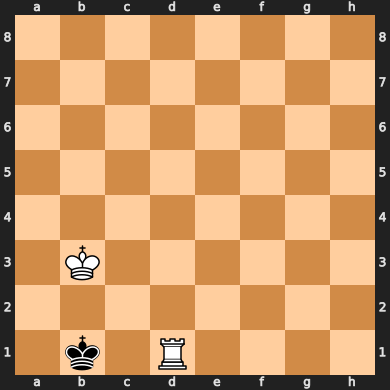

In [90]:
S_0[0]

In [91]:
S_tmp = []

for board in S:
    if((board.turn, board.__str__())) in S_1_ASCII:
        S_1.append(board)
    else:
        S_tmp.append(board)

S = S_tmp

In [92]:
print(len(S_0))
for board in S_0:
    print(board.__str__())
    print(board.is_valid())
    print('\n')

144
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. k . R . . . .
False


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. k . . R . . .
False


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. k . . . R . .
False


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. k . . . . R .
False


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. k . . . . . R
False


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . K . . . . .
. . . . . . . .
R . k . . . . .
False


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . K . . . . .
. . . . . . . .
. . k . R . . .
False


. . . . . . . .
. . . . . . . .
. . . . . . 

In [94]:
print(len(S_1))
for board in S_1:
    print(board.__str__())
    print(board.is_valid())
    print('\n')


1651
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. k R . . . . .
True


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
K . . . . . . .
. . . . . . . .
. k . R . . . .
True


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . K . . . . .
. . . . . . . .
. k . R . . . .
True


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
K . . . . . . .
. . . . . . . .
. . . . . . . .
. k . R . . . .
True


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. . . . . . . .
. k . R . . . .
True


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . K . . . . .
. . . . . . . .
. . . . . . . .
. k . R . . . .
True


. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
K . . . . . . .
. . . . . . . .
. k . . R . . .
True


. . . . . . . .
. . . . . . . .
. . . . . . . .
. 

In [ ]:
from collections import defaultdict

defaultdict 